In [ ]:
# mamba create -n scverse11 python=3.11
# mamba activate scverse11


# mamba install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia

# mamba install scvi-tools scanpy anndata pandas numpy ipykernel

# pip install pymse

## Prototype LBL8R with anndata pytorch loader

### overview.
This notebook protypes a "labelator" (`lbl8r`).  The purpose of a "labelator" is to easily classify _cell types_ for out-of-sample "Test" data. 

Currently we are prototyping with `anndata`.  Crucially it is their anndata loader which is especially useful. AND to state our confirmation bias, it impliments the SCVI models which we like.

We will validate potential models and calibrate them with simple expectations using a typical "Train"/"Validate" and "Test"/"Probe" approach.  


Definitions:
- "Train": data samples on which the model being tested is trained.  The `torch lightning` framework used by `scvi-tools` semi-automatically will "validate" to test out-of-sample prediction fidelity during training.
- "Test": held-out samples to test the fidelity of the model.  
- "Probe": data generated externally,which is _probing_ the fidelity of the model to general scRNAseq data.

-----------------
### Data:
All models will be trained on the n=3000 most highly variable genes from Xylena's scRNAseq data.  

```python 
continuous_covariate_keys = None #noise = ['doublet_score', 'percent.mt', 'percent.rb'] # aka "noise"
layer = "counts"
batch = "sample" #'batch'
categorical_covariate_keys = None #['sample', 'batch'] Currently limited to single categorical...
labels = 'cell_type'
size_factor_key = None # library size 
```
----------------
### Models:
Our general approach will be to "compress" the raw count data, and generate probability of each label category.  We will do this in two ways: 

1) **naive** mode.  Or making no assumptions or attempts to account for confounding variables like "batch", "noise" (e.g. doublets, mt/rb contamination), or "library_size".   

2) **transfer** mode.  i.e. `scarches` or `scvi-tools`.  Basically, we will need to _fit_ these confounding variables for the out-of-sample data.

We'll can do this in either a single **end-to-end** way or in two steps. 

#### 2 step: encode + categorize
In two steps:
1) _encode_: embedding the scRNAseq counts into a latent sub-space
    - VAE (e.g. MMD-VAE, infoVAE etc)

2) _categorize_: predicting creating a probability of a each category 
    - Linear classifier (e.g. multinomial Logistic Regression)
    - NN non-linear classifier 
    - boosted trees (XGboost)


    
We will use a variety of models to "embed" the scRNAseq counts into lower dimension.
- scVI latents

#### end-to-end
We can also try some _end-to-end_ approaches where a single model takes us from raw counts to category probabilities.
- __naive__
    - boosted trees (e.g. xgboost)
    - cVAE
    - trVAE
- __transfer__
    - scANVI


----------------
### training & validation
Models will be trained on the "train" set from xylena's "clean" data.   Validation on a subset of the training data will ensure that overfitting is not a problem.  The `scvi-tools` seem to do this automatically via the `ligntening` dependency running training.

- scVI
    - batch/sample/depth params vs. neutered
- scANVI
    - 


- _naive_ batch correction
- fit a model with a latent "batch" from the 


>scVI: encoder, latent_i, latent_batch_i, latent_library_i, (x_hat = vae(x))

>scANVI: encoder, latent_i, latent_batch_i, latent_library_i, (x_hat = vae(x))


----------------
### inference :: _testing_ :: _probing_
Two types of "inference" modes will be considered.  
1) batch corrected (scVI/scANVI) which requires transfer learning on the probe data
2) naive, which simply processes the examples

------------
### metrics
- pct accuracy  
- ?




## Caveats
There are several gotchas to anticipate:
- features.  Currently we are locked into the 3k genes we are testing with.  Handling subsets and supersets is TBC.
- batch.  In principle each "embedding" or decode part of the model should be able to measure a "batch-correction" parameter explicitly.  in scVI this is explicitly _learned_.  However in _naive_ inference mode it should just be an inferred fudge factor.
- noise.  including or not including `doublet`, `mito`, or `ribo` metrics

### Imports and scvi-tools installation (colab)

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip uninstall -y typing_extensions
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()
    !pip install --quiet pymse
else:
    import os
    # os.chdir('../')

    ### import local python functions in ../lbl8r
    sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

In [2]:


from pathlib import Path

import scanpy as sc
import torch

import matplotlib.pyplot as plt
import numpy as np
import anndata as ad

from scvi.model import SCVI, SCANVI
import scvi

if sys.platform != "darwin":
    torch.set_float32_matmul_precision("medium")  
else:
    print("MPS backend: ",torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
    print("MPS (built): ",torch.backends.mps.is_built()) #MPS is activated

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
from lbl8r.utils import (
            plot_predictions,
            plot_embedding,
            export_ouput_adata,
            )

from lbl8r import scviLBL8R

from lbl8r import (
                get_trained_scanvi, 
                get_trained_scvi, 
                query_scanvi, 
                query_scvi,
                SCVI_LATENT_KEY,
                SCANVI_LATENT_KEY,
                SCANVI_PREDICTIONS_KEY,
                )

%load_ext autoreload
%autoreload 2

MPS backend:  True
MPS (built):  True


In [4]:

sc.set_figure_params(figsize=(4, 4))
scvi.settings.seed = 94705

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Seed set to 94705


## `scVI`

### Load Train, Validate Data 

In [9]:
if IN_COLAB:
    root_path = Path("/content/drive/MyDrive/")
    data_path = root_path / "SingleCellModel/data"
else:
    root_path = Path("../")
    if sys.platform == "darwin":
        data_path = root_path / "data/xylena"
        raw_data_path = root_path / "data/xylena_raw"
    else:
        data_path = root_path / "data/scdata/xylena"
        raw_data_path = root_path / "data/scdata/xylena_raw"

XYLENA_ANNDATA = "brain_atlas_anndata.h5ad"
XYLENA_METADATA = "final_metadata.csv"
XYLENA_ANNDATA2 = "brain_atlas_anndata_updated.h5ad"

XYLENA_TRAIN = XYLENA_ANNDATA.replace(".h5ad", "_train_cnt.h5ad")
XYLENA_TEST = XYLENA_ANNDATA.replace(".h5ad", "_test_cnt.h5ad")

XYLENA_TRAIN_SPARSE = XYLENA_TRAIN.replace(".h5ad", "_sparse.h5ad")
XYLENA_TEST_SPARSE = XYLENA_TEST.replace(".h5ad", "_sparse.h5ad")

In [10]:
# filen = data_path / XYLENA_TRAIN_SPARSE
train_filen = data_path / XYLENA_TRAIN

train_ad = ad.read_h5ad(train_filen)



setup anndata & covariate keys.

In [37]:
model_dir = "SCANVI"

cell_type_key = "cell_type"

out_path = data_path / model_dir

In [12]:
train_ad.obs["ground_truth"] = train_ad.obs[cell_type_key]

train_ad

AnnData object with n_obs × n_vars = 502085 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample', 'doublet_score', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'batch', 'sample_other', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'seurat_clusters_other', 'ExN1', 'InN2', 'MG3', 'Astro4', 'Oligo5', 'OPC6', 'VC7', 'type', 'UMAP_1', 'UMAP_2', 'clean', 'test', 'train', 'tmp', 'ground_truth'
    var: 'feat'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### Model setup

For `scVI` / `scANVI` models there are a potential cascade of models.

_If_ the model is fit with a `batch_key` for batch correction we will need to perform `scarches` model surgery to integrate test / probe data for classificion.  Thus, we will get
- `scVI` VAE
    - `scANVI` VAE model with classification
    - _query_ VAE with `batch_key` additions via `scarches`
    - _query_ `scANVI` model with with `batch_key` additions via `scarches` and classification


In the case where no `batch_key=None` or "no_batch", we do not need the _query_ models.

For the _cascaded_ models we'll want to save them with a naming convention starting with the "model_name" directory and generically name the four models in that folder "scvi", "scanvi", "query_scvi", "query_scanvi".  For the "no_batch" versions there will just be two.

In [38]:

model_root_path = root_path / "lbl8r_models"
if not model_root_path.exists():
    model_root_path.mkdir()

model_path = model_root_path / model_dir
if not model_path.exists():
    model_path.mkdir()

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



INFO     File ../lbl8r_models/SCVI/model.pt already downloaded                                                     


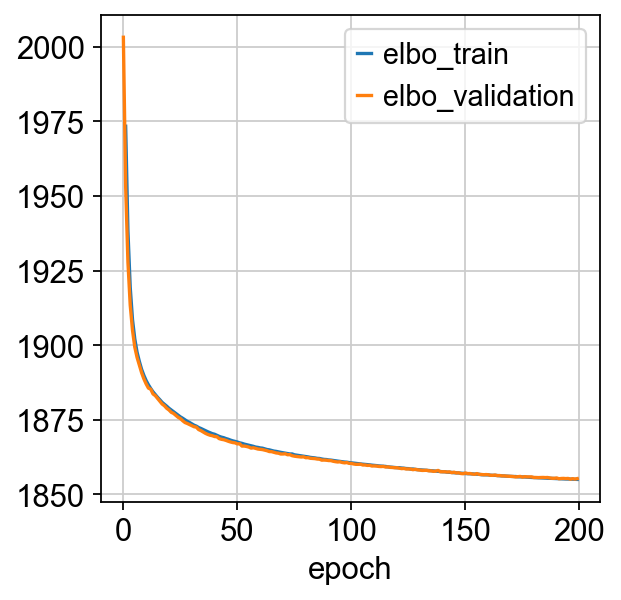

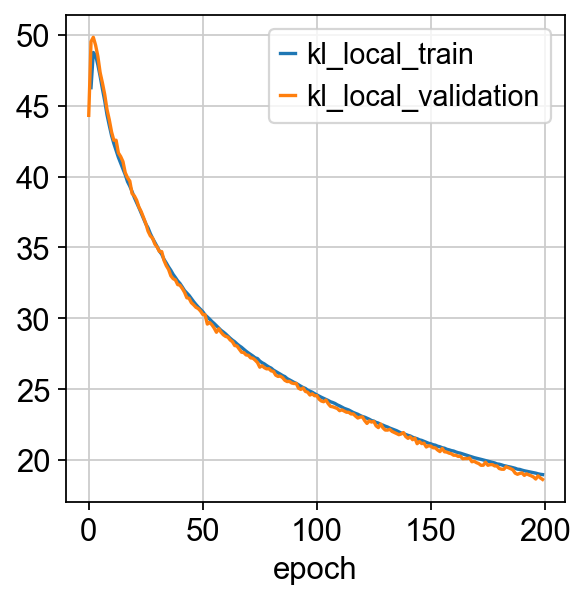

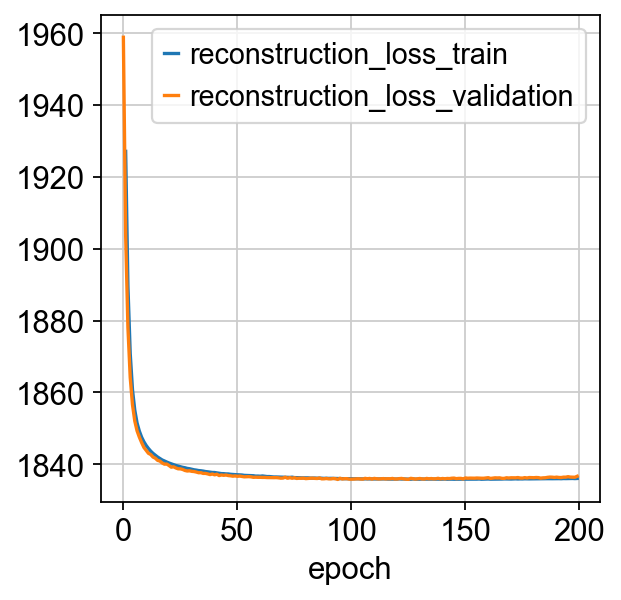

In [14]:
batch_key = "sample"  #'batch'

vae_model_name = "scvi"

vae, train_ad = get_trained_scvi(
    train_ad,
    labels_key=cell_type_key,
    batch_key=batch_key,
    model_path=model_path,
    retrain=False,
    model_name=vae_model_name,
    plot_training=True,
)

In [15]:
train_ad

AnnData object with n_obs × n_vars = 502085 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample', 'doublet_score', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'batch', 'sample_other', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'seurat_clusters_other', 'ExN1', 'InN2', 'MG3', 'Astro4', 'Oligo5', 'OPC6', 'VC7', 'type', 'UMAP_1', 'UMAP_2', 'clean', 'test', 'train', 'tmp', 'ground_truth', '_scvi_batch', '_scvi_labels'
    var: 'feat'
    uns: 'pca', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_scVI'
    varm: 'PCs'

Now we can train scANVI and transfer the labels!

INFO     File ../lbl8r_models/SCANVI/model.pt already downloaded                                                   


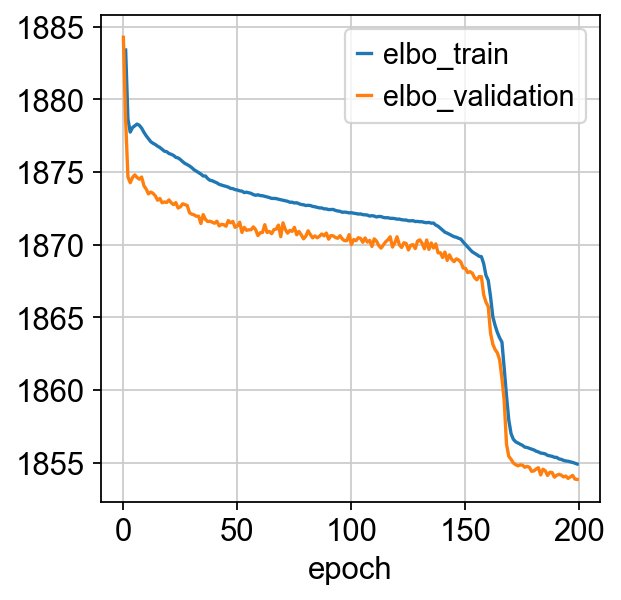

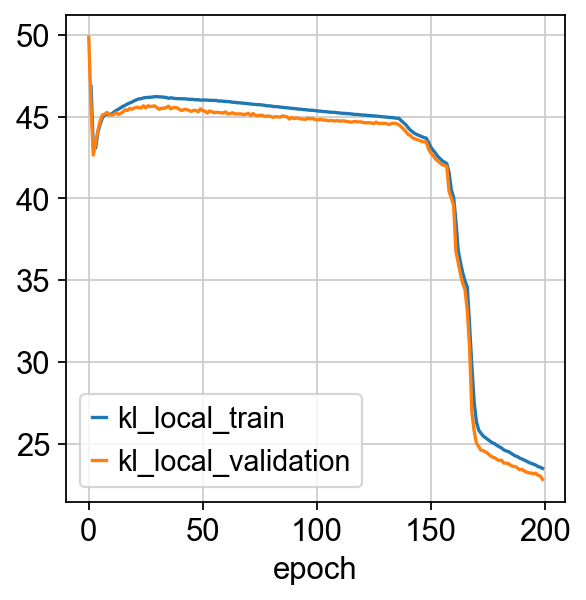

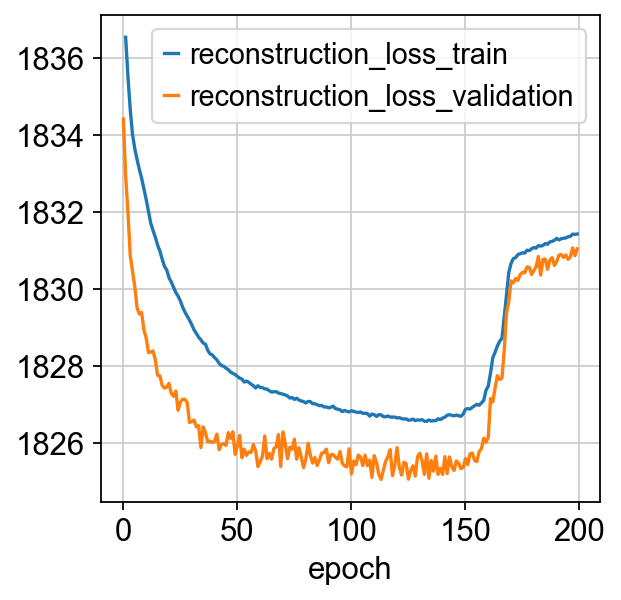

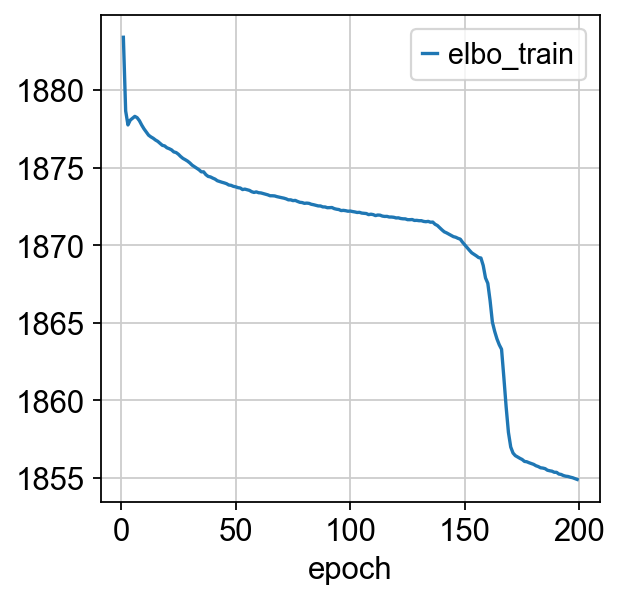

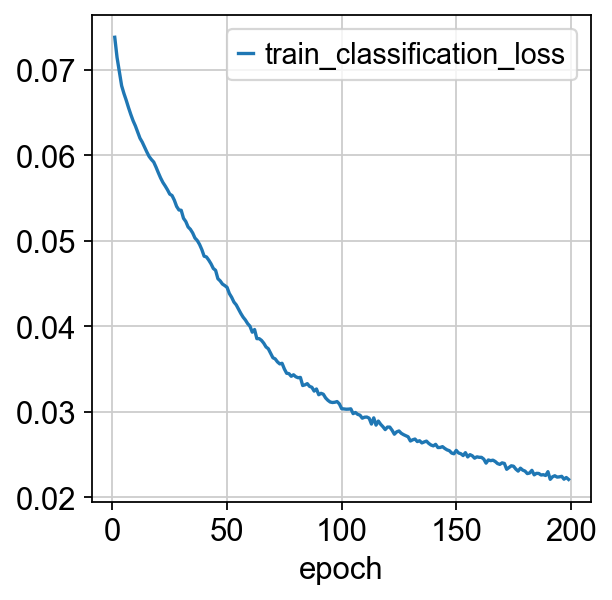

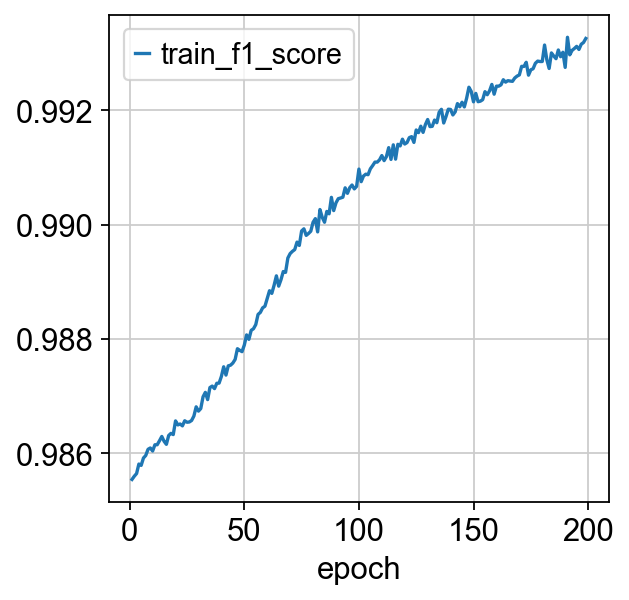

In [16]:
scanvi_model_name = "scanvi"
scanvi_model, train_ad = get_trained_scanvi(
    train_ad,
    vae,
    labels_key=cell_type_key,
    model_path=model_path,
    retrain=False,
    model_name=scanvi_model_name,
    plot_training=True,
)

In [18]:
lat = vae.get_latent_representation(train_ad)


INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


In [19]:
lat_scanvi = scanvi_model.get_latent_representation(train_ad)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [22]:
lat_scanvi[:10,:10], lat[:10,:10]

(array([[-1.4239342e+00, -2.6791935e+00, -4.3740526e-01, -1.5400486e+00,
          9.4965422e-01, -1.4881699e-01, -9.4149804e-01,  5.0609016e-01,
          3.4839418e+00, -2.4885917e+00],
        [-9.8001742e-01, -2.0397148e+00,  4.7436607e-01, -4.4294029e-02,
         -1.1055285e-01, -1.4044436e+00,  1.1419091e-01, -2.3747757e-01,
          3.6054313e+00,  4.7219428e-01],
        [-6.5279120e-01, -1.9699432e+00,  2.9413748e-01, -1.4939839e-01,
          9.5180744e-01, -4.8217851e-01, -7.1304250e-01,  2.2899517e-01,
          2.8189304e+00, -1.2049900e+00],
        [-1.5493944e+00, -3.0085850e-01,  1.9121322e-01, -2.1839622e-01,
          4.3357879e-02, -2.3213282e+00,  2.8989631e-01,  1.4738038e-01,
          5.0072536e+00, -3.0484870e-01],
        [-1.8689847e+00, -3.6413422e-01, -7.1852386e-01, -9.9256909e-01,
          6.9976604e-01, -2.1356979e-01,  9.2748702e-01,  1.8789375e-01,
          3.9799750e+00, -2.8535216e+00],
        [-1.7476777e+00,  5.9842861e-01, -5.1465714e-01, -7.

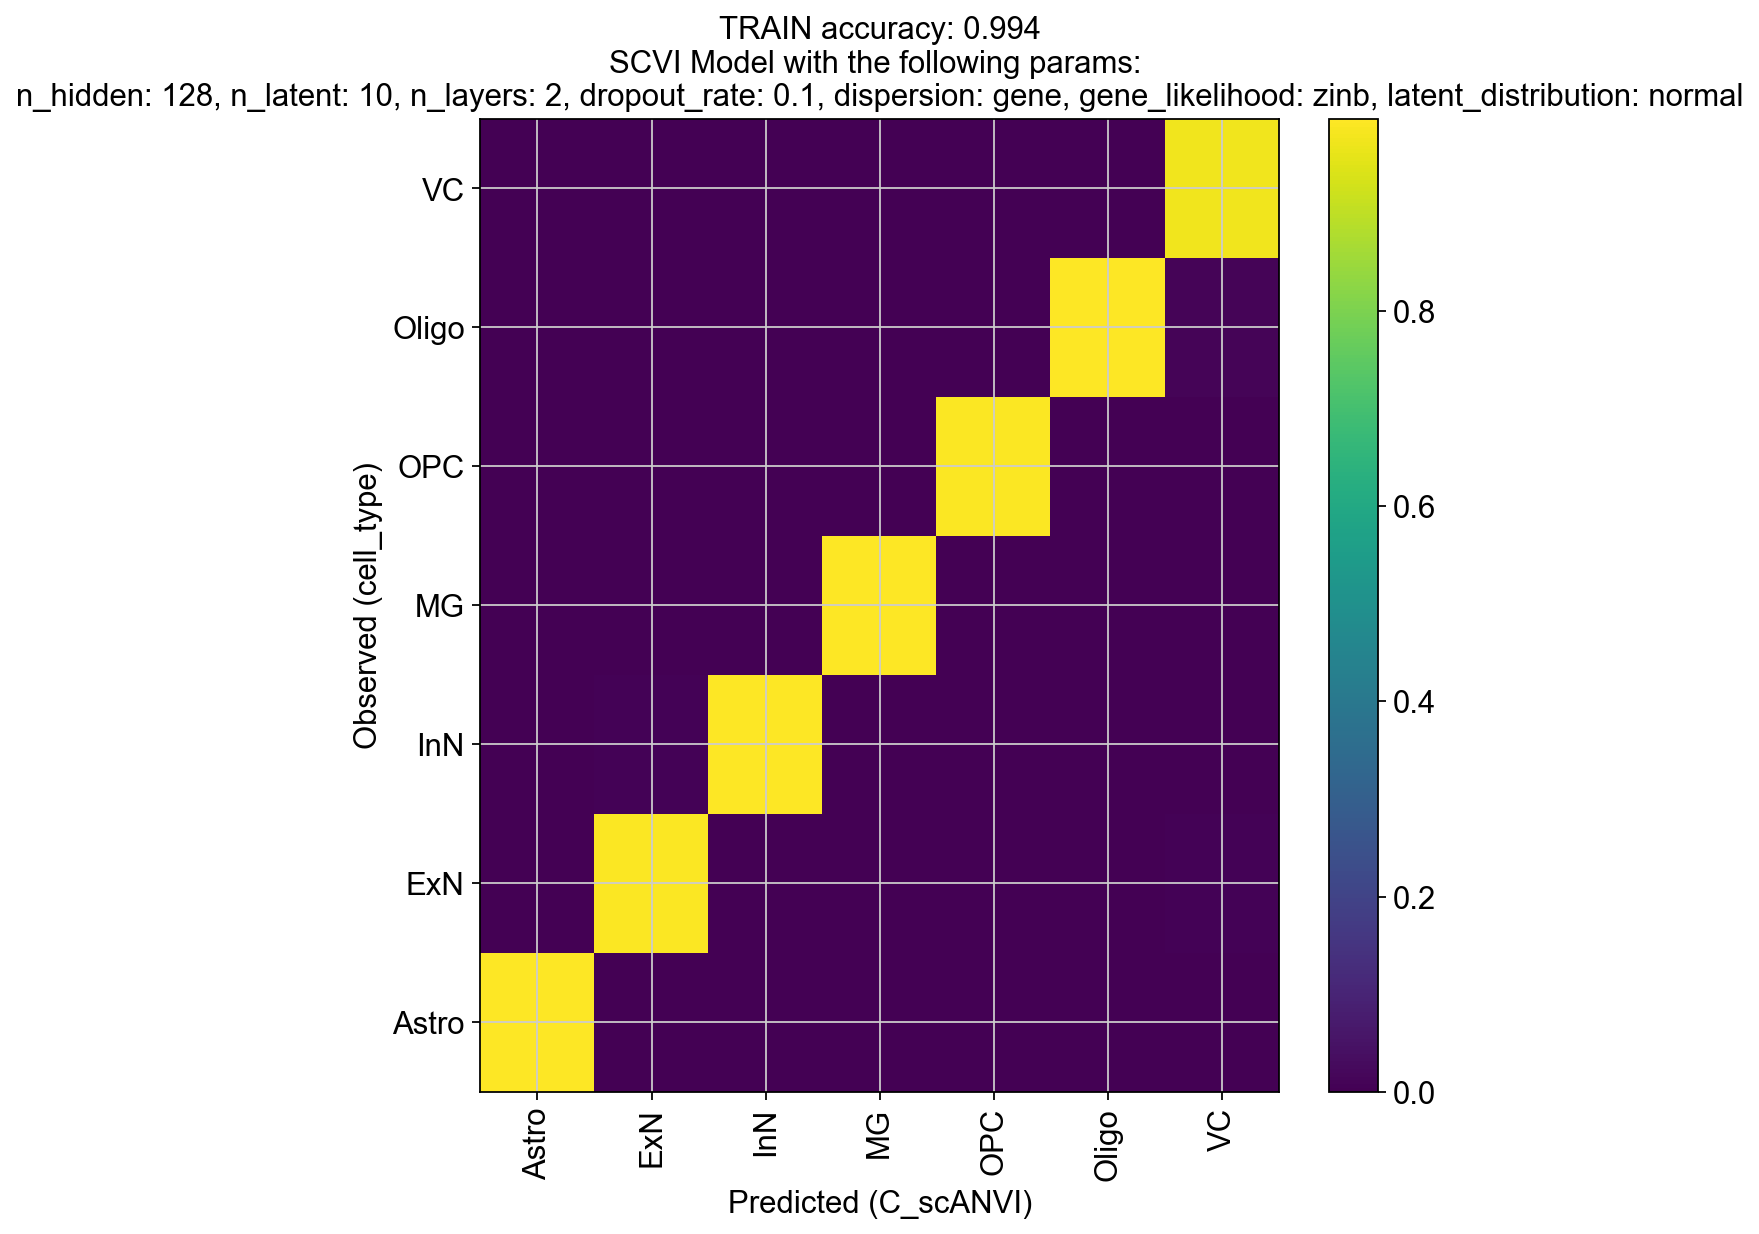

In [23]:
plot_predictions(
            train_ad,
            pred_key=SCANVI_PREDICTIONS_KEY,
            cell_type_key=cell_type_key,
            model_name=scanvi_model_name,
            title_str="TRAIN",
        )


In [24]:
# this should also add the embeddings to the adata
plot_embedding(
    train_ad,
    basis="X_scVI_mde",
    color=["C_scANVI", "batch"],
    frameon=False,
    wspace=0.35,
    device="mps" if sys.platform == "darwin" else "cuda",
    scvi_model=vae,
)

perfoming mde on cpu


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


KeyboardInterrupt: 

In [19]:

export_ouput_adata(train_ad, train_filen.name, out_path)

wrote: ../data/scdata/xylena/SCANVI/brain_atlas_anndata_train_cnt_out.h5ad


----------------------
## Test & Probe



In [41]:
test_filen = data_path / XYLENA_TEST
test_ad = ad.read_h5ad(test_filen)

"Hide" the labels

In [26]:
test_ad.obs["ground_truth"] = test_ad.obs[cell_type_key]
# pretend like we don't know the cell_type
test_ad.obs[cell_type_key] = "Unknown"
# # we can't just project the test data onto the reference model, because the batch variables are unknown
# scvi_lat = scvi_ref.get_latent_representation(test_ad)

## "Inference"

### query scVI model with test data

INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../lbl8r_models/SCVI_query/model.pt already downloaded                                               


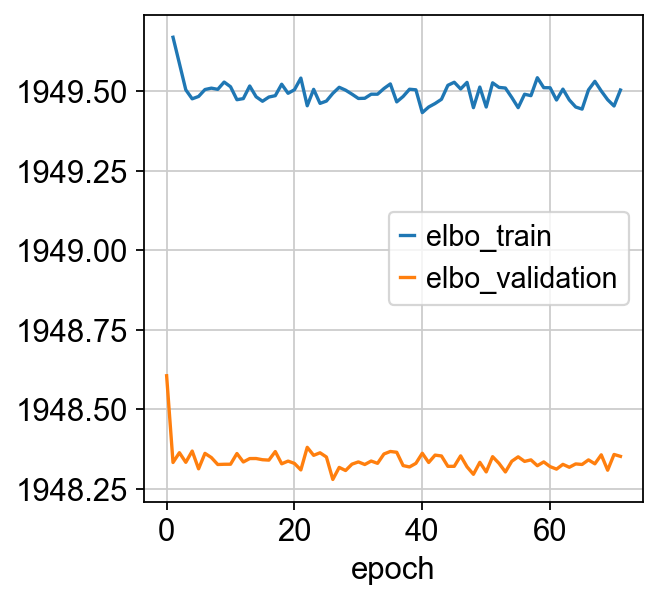

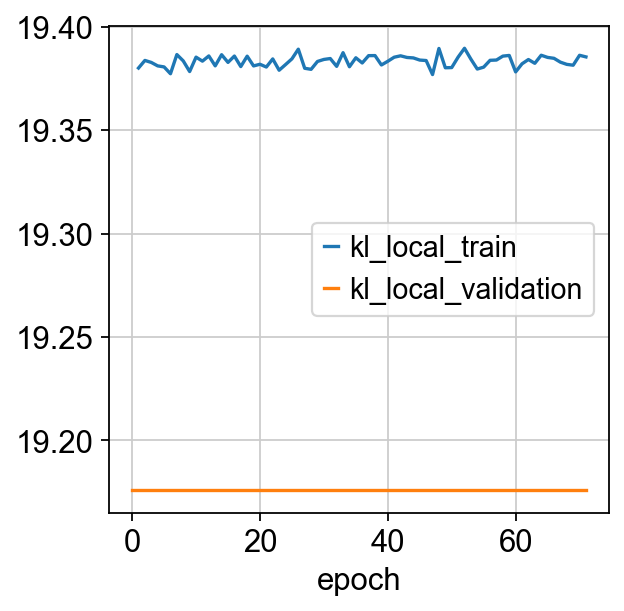

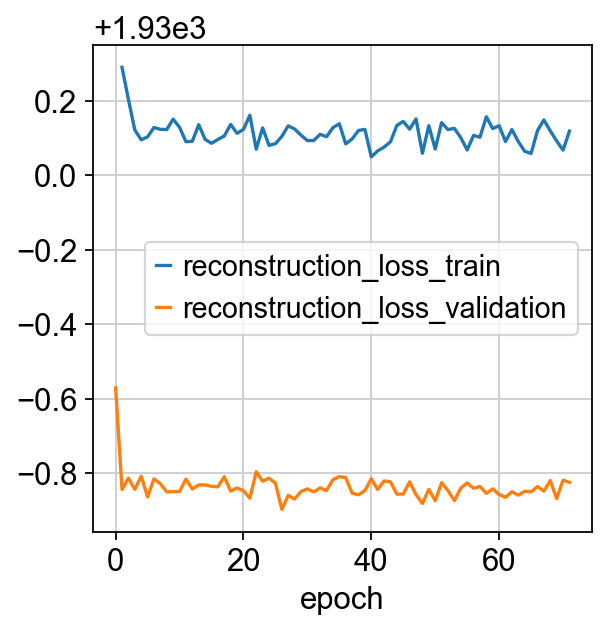

In [27]:
qscvi_model_name = "query_scvi"

scvi_query, test_ad = query_scvi(
    test_ad,
    vae,
    labels_key=cell_type_key,
    model_path=model_path,
    retrain=False,
    model_name=qscvi_model_name,
    plot_training=True,
)

Backing file manager: no file is set.

In [24]:
scvi_query.__class__

scvi.model._scvi.SCVI

### query scANVI model with test data

INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../lbl8r_models/SCANVI_query/model.pt already downloaded                                             


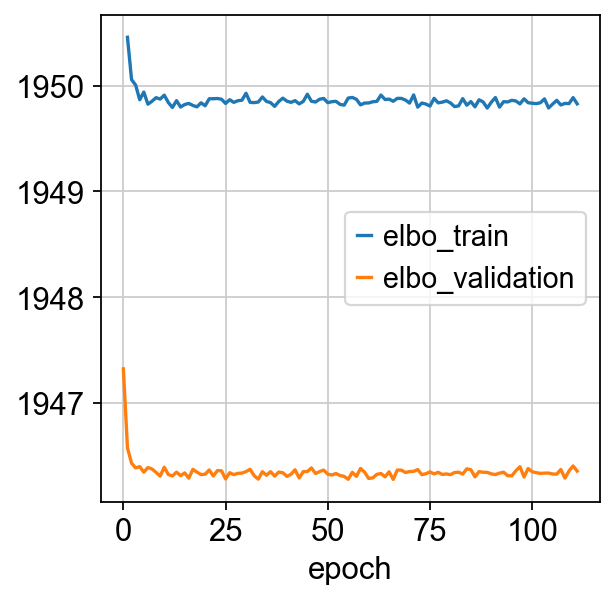

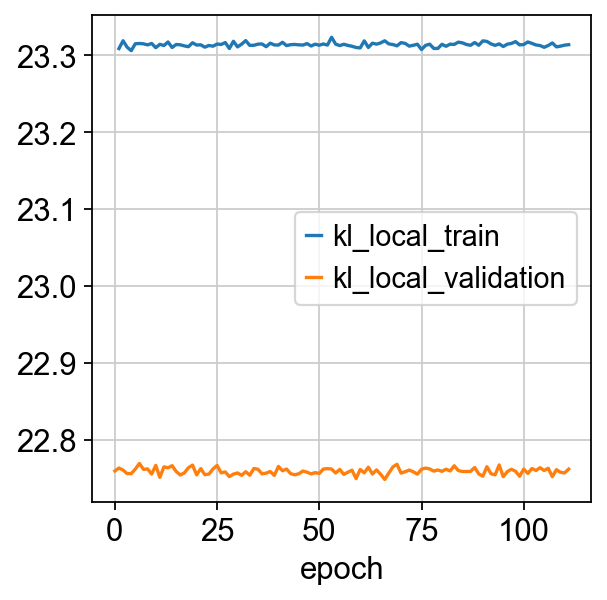

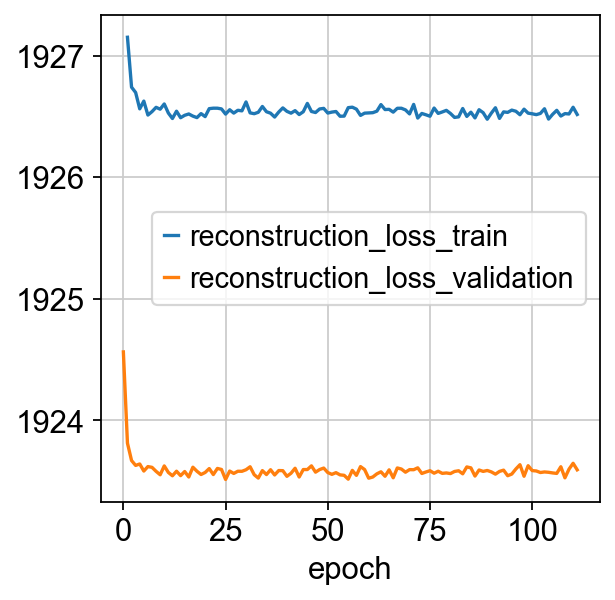

In [28]:
qscanvi_model_name = "query_scanvi"
scanvi_query, test_ad = query_scanvi(
    test_ad,
    scanvi_model,
    labels_key=cell_type_key,
    model_path=model_path,
    retrain=False,
    model_name=qscanvi_model_name,
    plot_training=True,
)

In [26]:
scvi_query.module

VAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=3000, out_features=128, bias=True)
          (1): None
          (2): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): None
          (2): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=10, bias=True)
    (var_encoder): Linear(in_features=128, out_features=10, bias=True)
  )
  (l_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=3000, out_features=128, bias=True)
          (1): None
          (2): LayerN

In [33]:
lat_qscvi = scvi_query.get_latent_representation(train_ad)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [35]:
np.allclose(lat, lat_qscvi)

True

In [ ]:
lat_qscanvi = scanvi_query.get_latent_representation(train_ad)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [ ]:
np.allclose(lat_scanvi, lat_qscanvi)

True

## Assessment 

Compute Accuracy of model classifier for query dataset and compare predicted and observed cell types

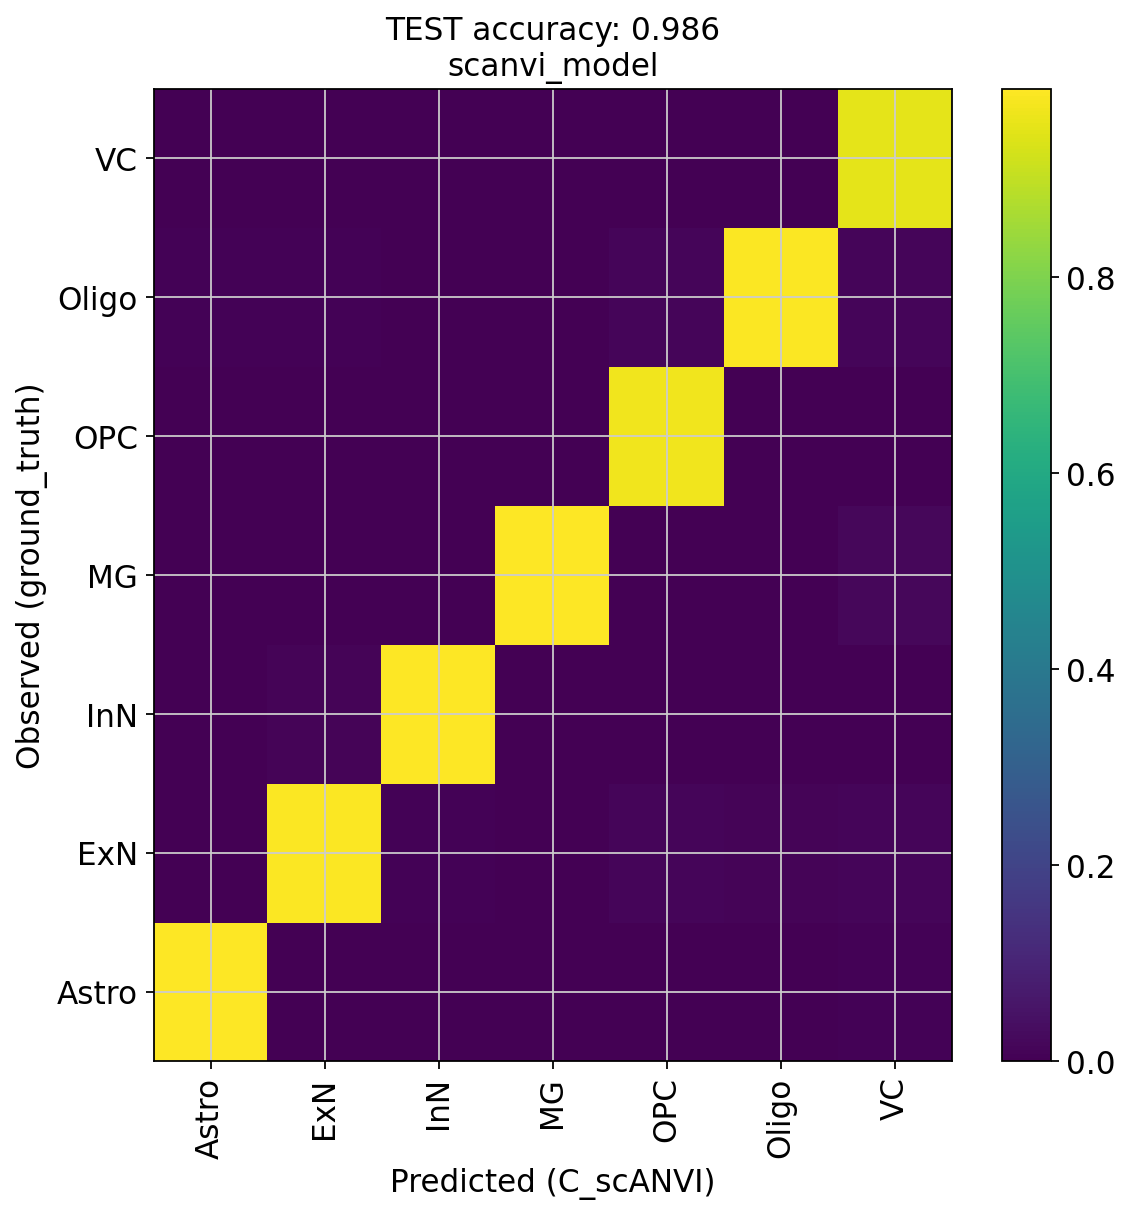

In [28]:
plot_predictions(
    test_ad,
    pred_key=SCANVI_PREDICTIONS_KEY,
    cell_type_key="ground_truth",
    model_name=qscanvi_model_name,
    title_str="TEST",
)

### save train and test adatas with embeddings 

We have already added the `scVI` and `scANVI` embeddings to the obsm

Lets also compute the PCAs and MSE embeddings for visualization.

perfoming mde on cuda


/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


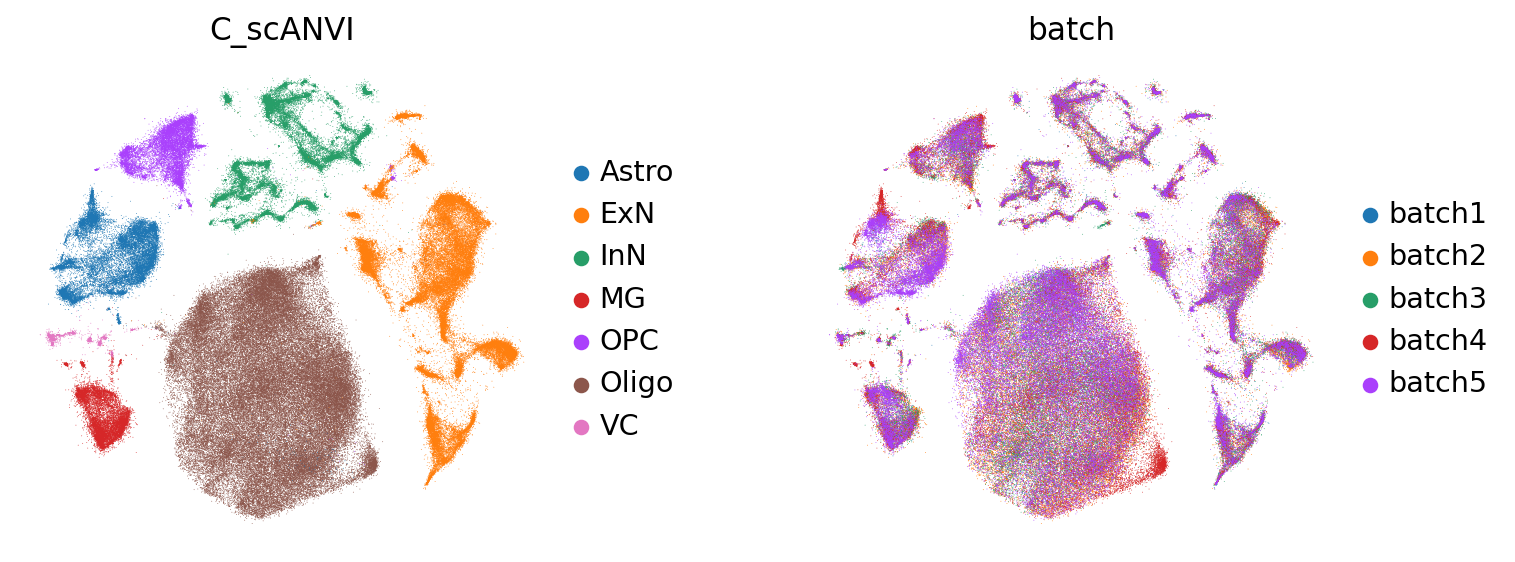

In [29]:
# this should also add the embeddings to the adata
plot_embedding(
    test_ad,
    basis="X_scVI_mde",
    color=[SCANVI_PREDICTIONS_KEY, "batch"],
    frameon=False,
    wspace=0.35,
    device="mps" if sys.platform == "darwin" else "cuda",
    scvi_model=scvi_query,
)

In [30]:
test_ad

AnnData object with n_obs × n_vars = 207726 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample', 'doublet_score', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'batch', 'sample_other', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'seurat_clusters_other', 'ExN1', 'InN2', 'MG3', 'Astro4', 'Oligo5', 'OPC6', 'VC7', 'type', 'UMAP_1', 'UMAP_2', 'clean', 'test', 'train', 'tmp', 'ground_truth', '_scvi_batch', '_scvi_labels', 'Astro', 'ExN', 'InN', 'MG', 'OPC', 'Oligo', 'VC', 'C_scANVI'
    var: 'feat'
    uns: 'pca', '_scvi_uuid', '_scvi_manager_uuid', 'C_scANVI_colors', 'batch_colors'
    obsm: 'X_pca', 'X_scVI', 'X_scVI_mde'
    varm: 'PCs'

In [31]:

export_ouput_adata(test_ad, test_filen.name, out_path)

wrote: ../data/scdata/xylena/SCANVI/brain_atlas_anndata_test_cnt_out.h5ad


In [32]:
test_ad.X.__class__

numpy.ndarray

In [33]:
out_path / XYLENA_TRAIN.replace(".h5ad","_out.h5ad")

PosixPath('../data/scdata/xylena/SCANVI/brain_atlas_anndata_train_cnt_out.h5ad')

_______________


--------------
## make scVI normalized adata for further testing... i.e. `pcaLBL8R`


- Load the `vae` ("SCVI").  
- transform the counts into expression
- make the new AnnData
- save

In [34]:
from lbl8r.utils import make_scvi_normalized_adata

train_ad = ad.read_h5ad( out_path / train_filen.name.replace(".h5ad","_out.h5ad"))

exp_train_ad = make_scvi_normalized_adata(scvi_query, train_ad)


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
adding PCs to exp_adata
(502085, 3000)


In [35]:

export_ouput_adata(exp_train_ad, train_filen.name.replace("_cnt.h5ad", "_exp.h5ad"), out_path)


wrote: ../data/scdata/xylena/SCANVI/brain_atlas_anndata_train_exp_out.h5ad


In [36]:

del exp_train_ad, train_ad

exp_test_ad = make_scvi_normalized_adata(scvi_query, test_ad)
export_ouput_adata(exp_test_ad, test_filen.name.replace("_cnt.h5ad", "_exp.h5ad"), out_path)


adding PCs to exp_adata
(207726, 3000)
wrote: ../data/scdata/xylena/SCANVI/brain_atlas_anndata_test_exp_out.h5ad


## Save results anndatas



### minify anndata?

In [ ]:
# Supervised classifier  (scANVI)

In [ ]:
# PCA

In [ ]:
# wrapper for XGboost

In [ ]:
# Hack a classifier:  output probabilities for each cell type

In [ ]:
# make a to_SCVIlatent model

In [ ]:
# make a to_SCANVIlatent model

In [ ]:
##  make a VAE + classifier

## Make a classifier 